## **What Features make a Hit?**

### **Problem Statement**

The billboard 100 ranks the best tracks every week based on radio play, streaming activity and sales. However, with the rise of platforms like TikTok, it’s increasingly difficult to distinguish lasting hits from short-lived viral trends. As a data analyst, your task is to examine billboard hot 100 data for the past 2 decades to uncover what makes a track a “hit”. Since genre classifications are unreliable, this project focuses on numerical audio features such as tempo, popularity, danceability. The objective is to identify trends over time and determine which features correlate most strongly with higher chart rankings.

### **What's a Hit?**

A track is a "hit" if it reached the top 10 on any weekly Billboard chart and stayed on the chart for at least 4 weeks.

In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

plt.style.use("fivethirtyeight")

In [2]:
billboard_data = pd.read_csv("../data/processed/cleaned_billboard_data.csv")

In [3]:
billboard_data["is_hit"] = ((billboard_data["weeks_rank"] <= 10) & (billboard_data["weeks_on_chart"] >= 4)).astype(int)

In [4]:
feature_cols = ["Tempo", "Explicit", "Popularity", "Danceability", "Energy", "Key", "Loudness", "Mode", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Time Signature"]


In [5]:
for col in feature_cols:
    r, p = stats.pointbiserialr(billboard_data[col], billboard_data["is_hit"])
    print(f"{col:18}: r={r:.2f}, p={p:.2e}")

Tempo             : r=-0.02, p=2.01e-11
Explicit          : r=0.01, p=1.66e-03
Popularity        : r=0.22, p=0.00e+00
Danceability      : r=0.09, p=8.91e-245
Energy            : r=-0.01, p=3.52e-04
Key               : r=-0.01, p=5.12e-07
Loudness          : r=0.02, p=4.77e-17
Mode              : r=-0.04, p=4.83e-39
Speechiness       : r=0.01, p=1.84e-02
Acousticness      : r=-0.01, p=2.05e-07
Instrumentalness  : r=-0.01, p=1.00e-03
Liveness          : r=-0.01, p=6.18e-08
Valence           : r=0.07, p=3.05e-124
Time Signature    : r=0.01, p=8.64e-04


Point Biserial works on the assumption that the continuous and binary features have a linear relationship but since the correlation values show weak relationships, mutual information is implemented since it captures both linear and non-linear relationships and is more general than correlation coefficients.

In [6]:
from sklearn.feature_selection import mutual_info_classif
X = billboard_data[feature_cols]
y = billboard_data["is_hit"]
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

In [7]:
mi_df = pd.DataFrame({"features":feature_cols, "mi_score":mi_scores})
mi_df.sort_values(by="mi_score", ascending=False, inplace=True, ignore_index=True)
mi_df.head(10)


,features,mi_score
0,Tempo,0.133621
1,Loudness,0.110451
2,Acousticness,0.070698
3,Speechiness,0.044688
4,Instrumentalness,0.044070
5,Liveness,0.041215
6,Valence,0.039791
7,Popularity,0.036071
8,Danceability,0.032708
9,Energy,0.028312


From the scores returned, we can say that tempo and loudness have strong predictable power along with acousticness and speechiness potentially tying to genre preference or stylistic biases. Since none of the scores are above 0.15, it can't be assumed that each feature has strong standalone predictive power but suggests that the characteristics of a hit are multidimensional with combination of features contributing to success.

In [8]:
top_features = mi_df.head(5)["features"].values
hits = billboard_data[billboard_data["is_hit"] == 1]
non_hits = billboard_data[billboard_data["is_hit"] == 0]
for  col in top_features:
    t_stat, p_val = stats.ttest_ind(hits[col], non_hits[col], equal_var=False)
    print(f"{col:18}: t_score={t_stat:.2f}, p_value={p_val:.2e}")

Tempo             : t_score=-6.82, p_value=9.60e-12
Loudness          : t_score=9.73, p_value=2.67e-22
Acousticness      : t_score=-5.49, p_value=4.06e-08
Speechiness       : t_score=2.50, p_value=1.24e-02
Instrumentalness  : t_score=-3.84, p_value=1.25e-04


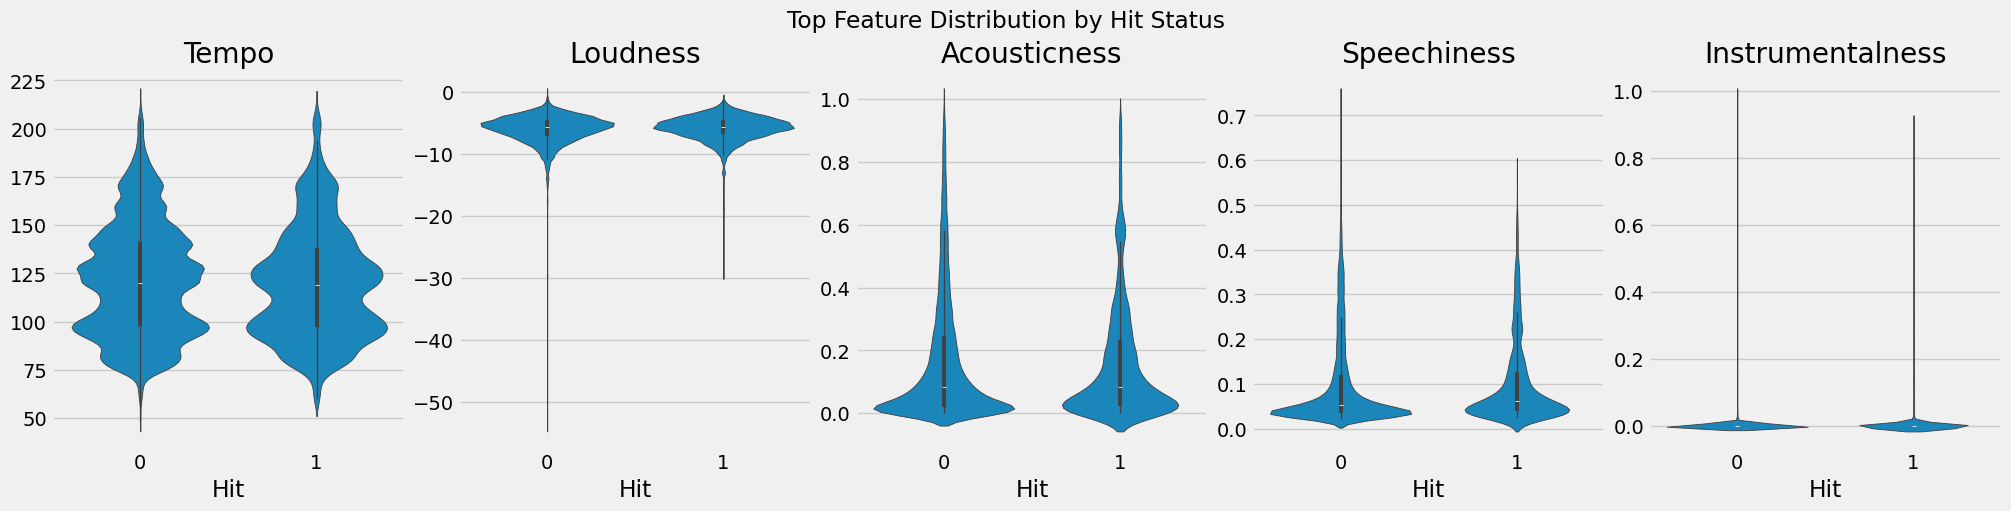

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)
for ax, feature in zip(axs, top_features):
    sns.violinplot(x="is_hit", y=feature, ax=ax, data=billboard_data)
    ax.set_title(f"{feature}")
    ax.set_xlabel("Hit")
    ax.set_ylabel("")
    
plt.suptitle("Top Feature Distribution by Hit Status")
plt.show()

C:\Users\Tunchiie\AppData\Local\Temp\ipykernel_26308\3845445561.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = billboard_data.groupby(f"{feature}_bin")["is_hit"].mean().reset_index()
C:\Users\Tunchiie\AppData\Local\Temp\ipykernel_26308\3845445561.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = billboard_data.groupby(f"{feature}_bin")["is_hit"].mean().reset_index()
C:\Users\Tunchiie\AppData\Local\Temp\ipykernel_26308\3845445561.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

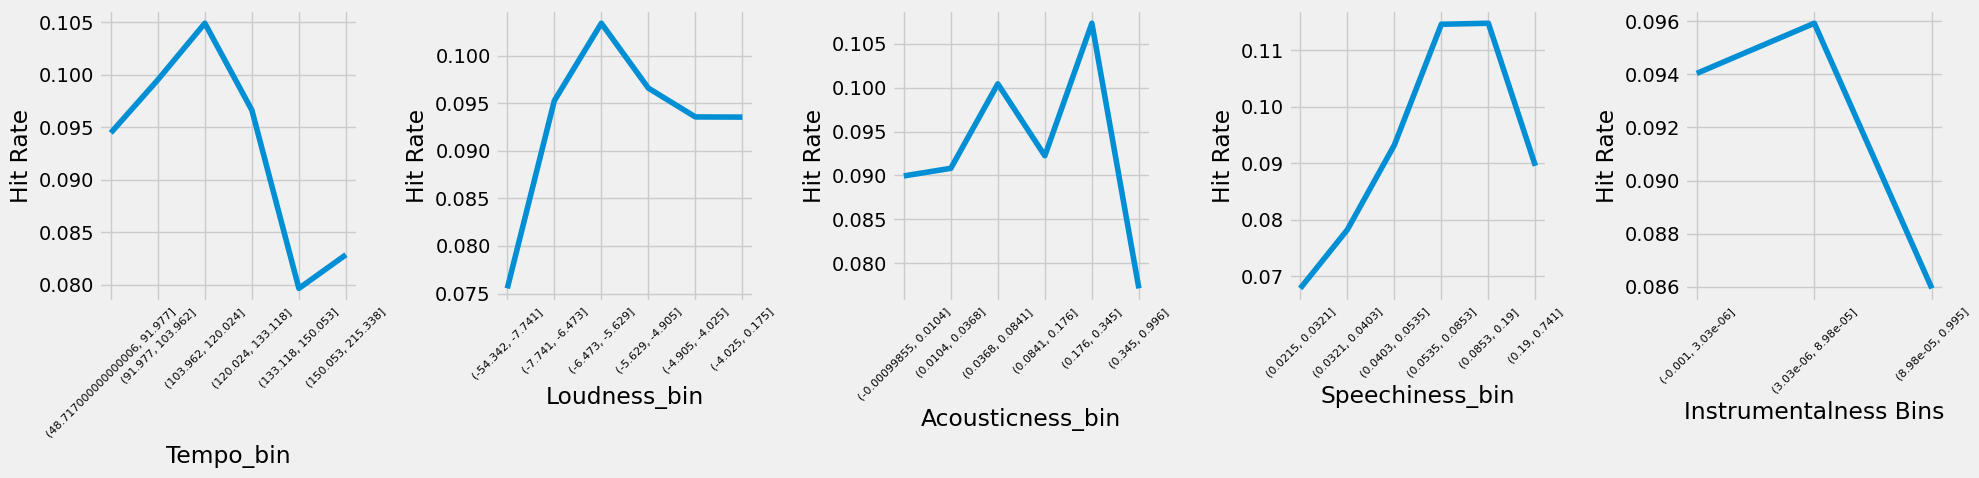

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)
for ax, feature in zip(axs, top_features):
    billboard_data[f"{feature}_bin"] = pd.qcut(billboard_data[feature], q=6, duplicates="drop")
    binned = billboard_data.groupby(f"{feature}_bin")["is_hit"].mean().reset_index()
    binned["midpoint"] = binned[f"{feature}_bin"].apply(lambda x: x.mid)
    sns.lineplot(x=binned[f"{feature}_bin"].astype(str), y="is_hit", data=binned, ax=ax)
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.set_ylabel("Hit Rate")
    plt.xlabel(f"{feature} Bins")
plt.title("")
plt.tight_layout()
plt.show()

#### Feature Importance by Decade

In [11]:
def getSeason(date):
    if date.month in [9 , 10, 11]:
        return "Fall"
    if date.month in [12, 1, 2]:
        return "Winter"
    if date.month in [3, 4, 5]:
        return "Spring"
    if date.month in [6, 7, 8]:
        return "Summer"

In [12]:
temp_data = billboard_data.copy()
temp_data["date"] = pd.to_datetime(temp_data["date"])
temp_data["year"] = pd.to_datetime(temp_data["date"]).dt.year
temp_data["season"] = temp_data["date"].apply(getSeason)
temp_data["decade"] = pd.cut(
    temp_data["year"],
    bins=[1999, 2009, 2019, 2029],
    labels=["2000s", "2010s", "2020s"]
)

In [13]:
hits = temp_data[temp_data["is_hit"] == 1]

In [14]:
decade_anova_results = []
for feature in top_features:
    grouped = [group[feature].dropna() for i, group in hits.groupby("decade")]
    
    f_stat, p_value = stats.f_oneway(*grouped)
    decade_anova_results.append(
        {
            "feature" : feature,
            "F_statistic": round(f_stat, 3),
            "p_value": format(p_value, ".3e")
        }
    )

C:\Users\Tunchiie\AppData\Local\Temp\ipykernel_26308\512972277.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = [group[feature].dropna() for i, group in hits.groupby("decade")]


In [15]:
decade_results = pd.DataFrame(decade_anova_results)
decade_results.sort_values("F_statistic", ascending=False)

,feature,F_statistic,p_value
2,Acousticness,193.420,1.964e-83
3,Speechiness,106.873,9.646e-47
1,Loudness,92.569,1.252e-40
0,Tempo,44.287,6.845e-20
4,Instrumentalness,3.107,4.478e-02


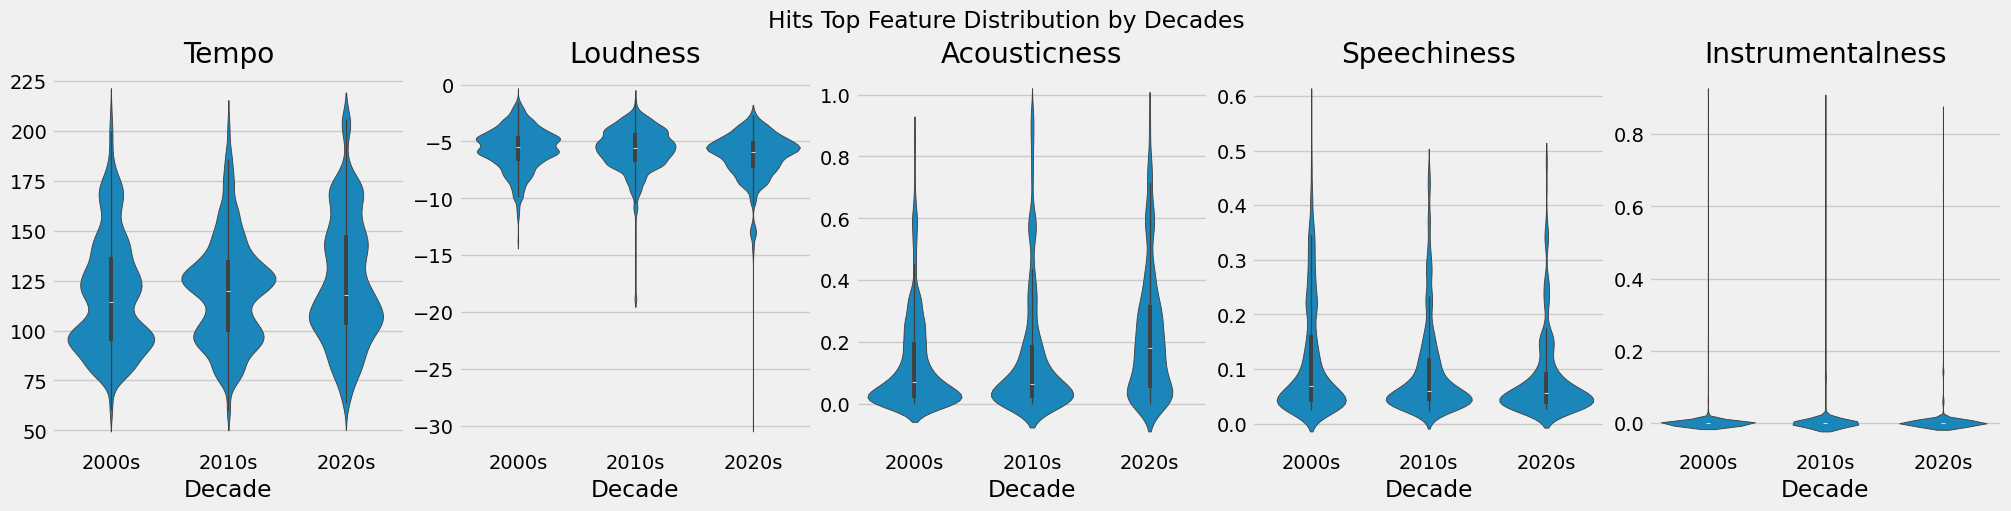

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)
for ax, feature in zip(axs, top_features):
    sns.violinplot(x="decade", y=feature, ax=ax, data=hits)
    ax.set_title(f"{feature}")
    ax.set_xlabel("Decade")
    ax.set_ylabel("")
    
plt.suptitle("Hits Top Feature Distribution by Decades")
plt.show()

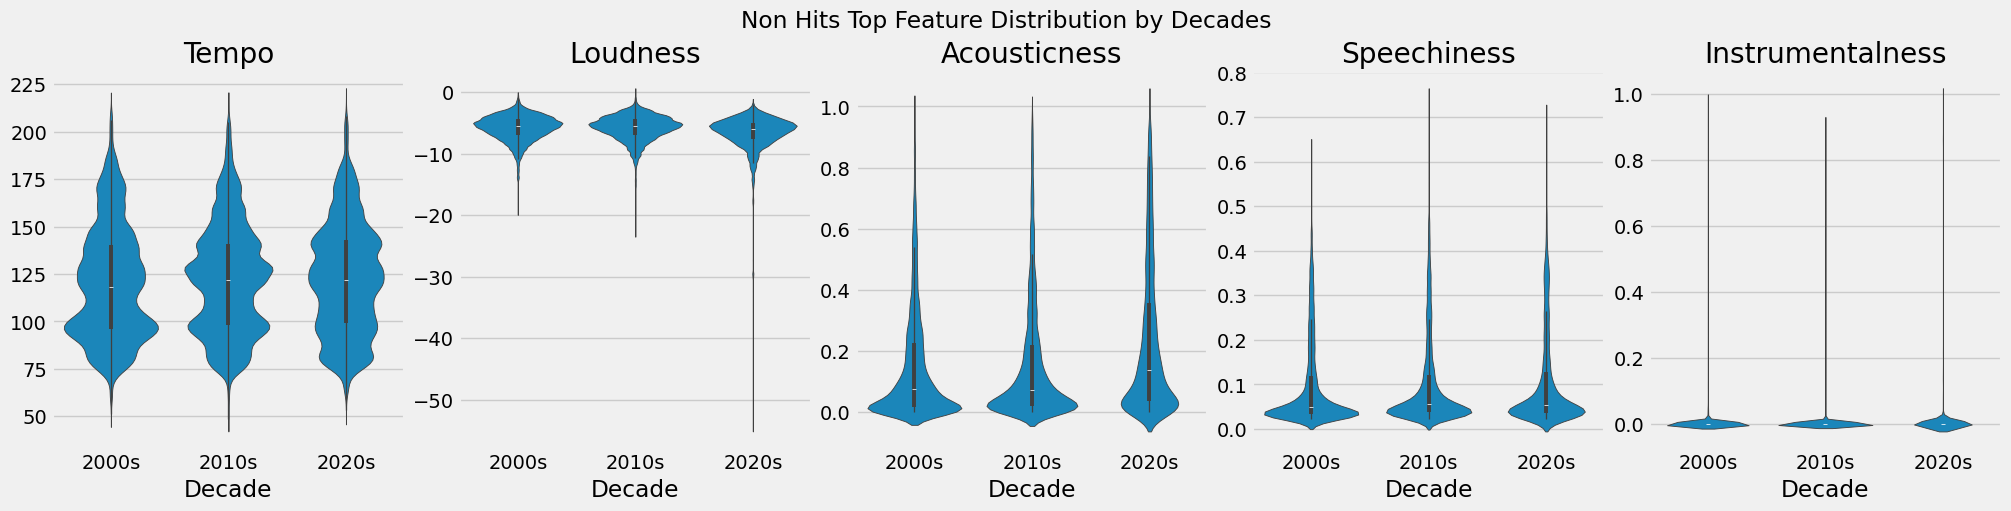

In [17]:
non_hits = temp_data[temp_data["is_hit"] == 0]
fig, axs = plt.subplots(1, 5, figsize=(20,5), constrained_layout=True)
for ax, feature in zip(axs, top_features):
    sns.violinplot(x="decade", y=feature, ax=ax, data=non_hits)
    ax.set_title(f"{feature}")
    ax.set_xlabel("Decade")
    ax.set_ylabel("")
    
plt.suptitle("Non Hits Top Feature Distribution by Decades")
plt.show()

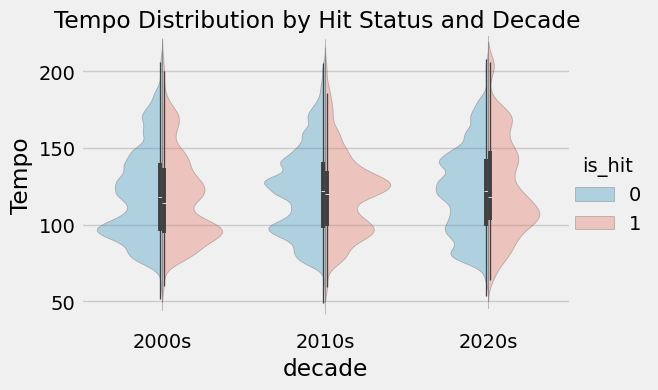

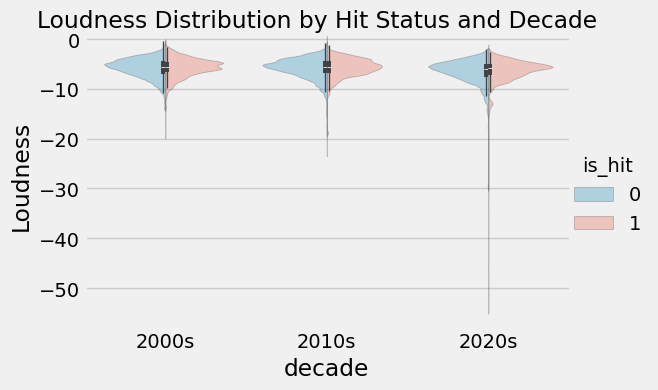

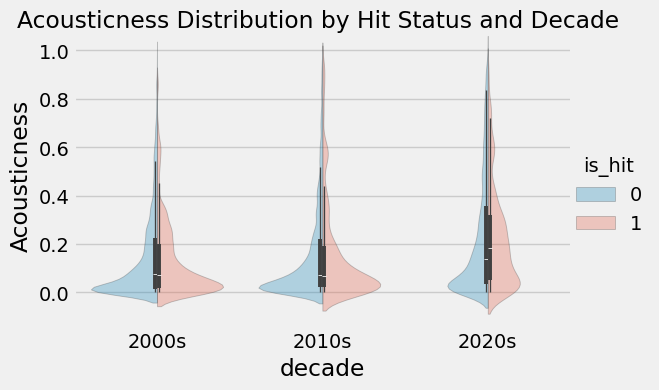

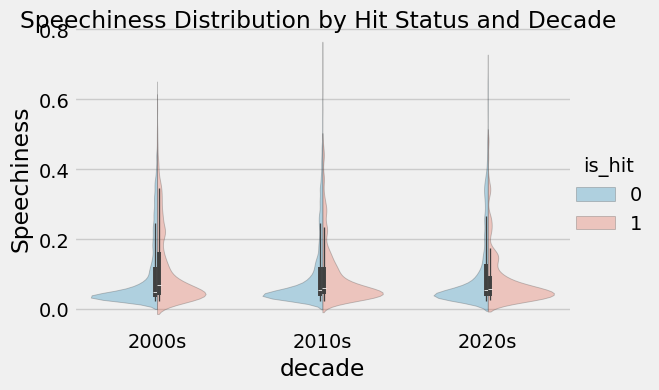

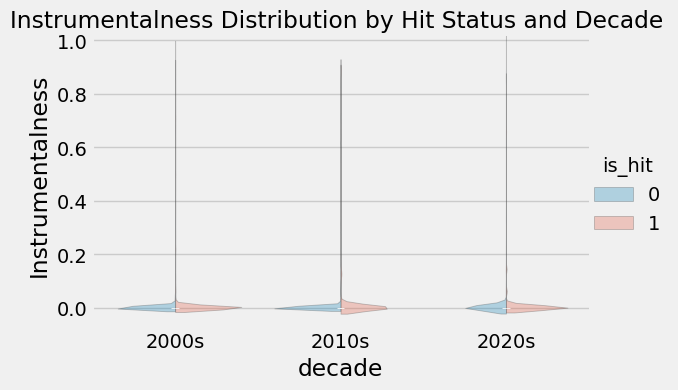

In [18]:
for feature in top_features:
    sns.catplot(
        kind="violin",
        data=temp_data,
        x="decade",
        y=feature,
        hue="is_hit",
        alpha = 0.3,
        aspect=1.5,
        split=True,
        height=4
    ).fig.suptitle(f"{feature} Distribution by Hit Status and Decade")
    plt.savefig(f"../Images/{feature}_violin_plot.png")
plt.show()


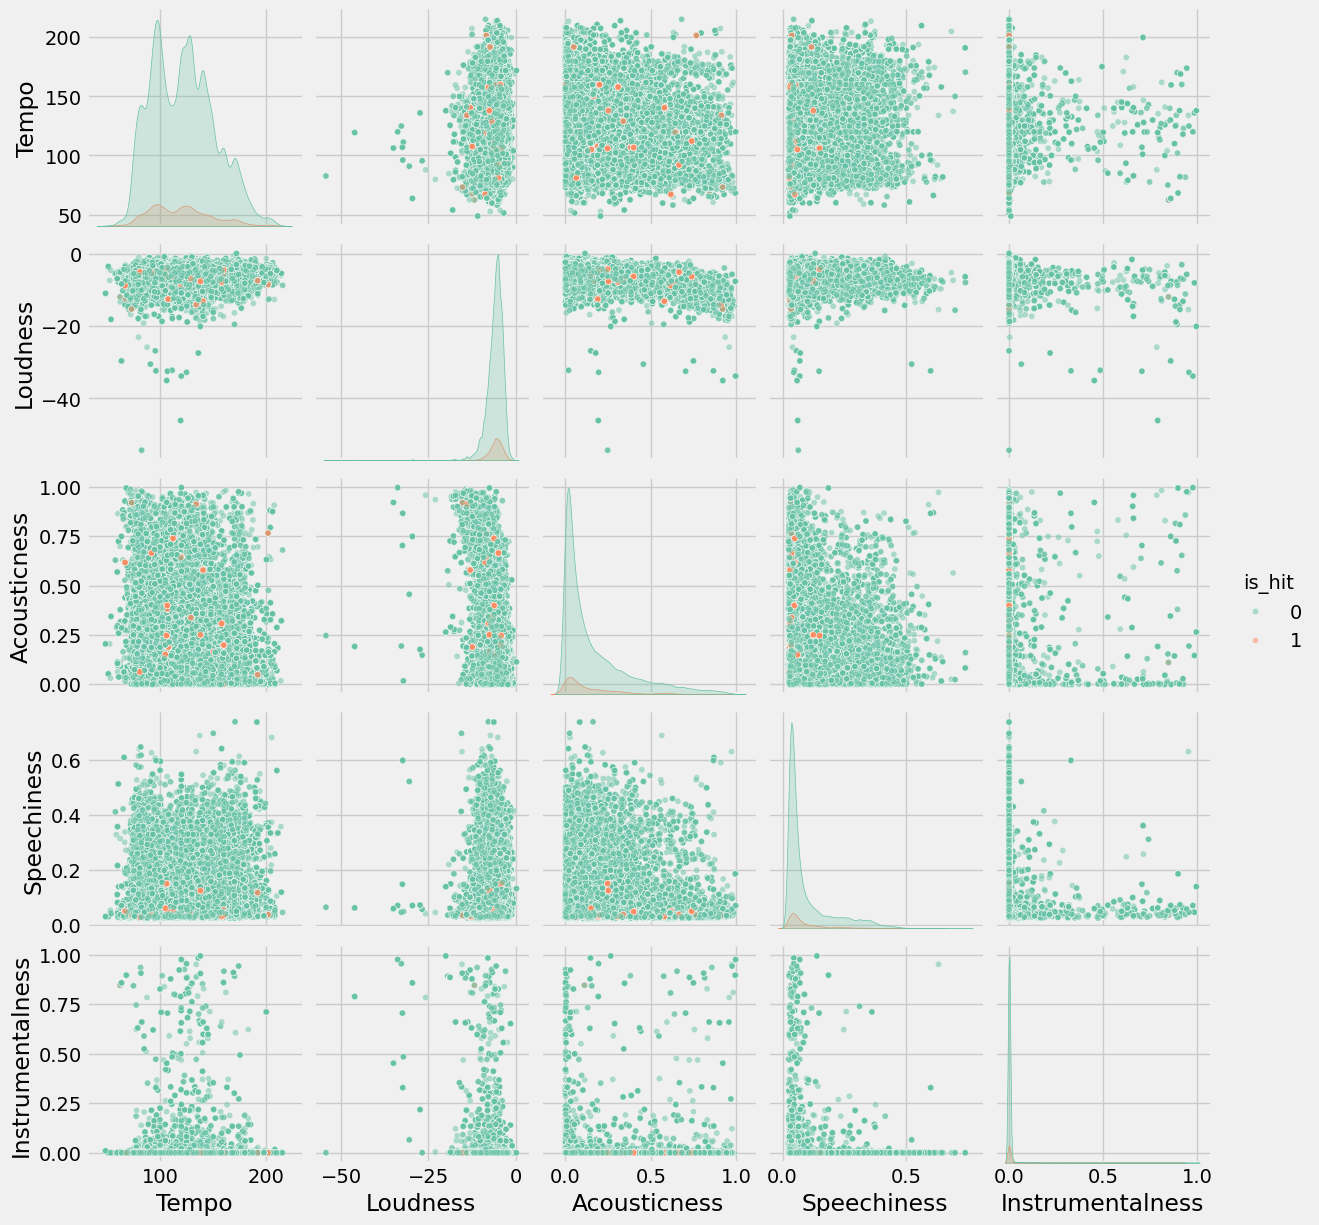

In [19]:
plot_data = temp_data[list(top_features) + ["is_hit"]].copy()
sns.pairplot(
    plot_data,
    hue="is_hit",
    palette="Set2",
    plot_kws={"alpha":0.5, "s":20},
    diag_kind="kde"
)
plt.show()

#### Feature Importance by Season

In [20]:
season_anova_results = []
for feature in top_features:
    grouped = [group[feature].dropna() for i, group in hits.groupby("season")]
    
    f_stat, p_value = stats.f_oneway(*grouped)
    season_anova_results.append(
        {
            "feature" : feature,
            "F_statistic": round(f_stat, 3),
            "p_value": format(p_value, ".3e")
        }
    )

In [21]:
season_results = pd.DataFrame(season_anova_results)
season_results.sort_values("F_statistic", ascending=False)

,feature,F_statistic,p_value
2,Acousticness,42.400,2.995e-27
1,Loudness,32.121,1.131e-20
4,Instrumentalness,3.596,1.295e-02
0,Tempo,1.036,3.753e-01
3,Speechiness,0.927,4.266e-01


In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for feature in top_features:
    turkey_result = pairwise_tukeyhsd(endog=hits[feature], groups=hits["season"], alpha=0.05)
    print(f"{feature} Turkey Result: ")
    print(turkey_result)
    print("\n")

Tempo Turkey Result: 
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Fall Spring  -0.4095 0.9448 -2.2998 1.4807  False
  Fall Summer  -1.2703 0.3119 -3.1651 0.6245  False
  Fall Winter  -0.5969 0.8473 -2.4781 1.2842  False
Spring Summer  -0.8608 0.6401 -2.7365  1.015  False
Spring Winter  -0.1874 0.9939 -2.0494 1.6746  False
Summer Winter   0.6734 0.7904 -1.1932   2.54  False
---------------------------------------------------


Loudness Turkey Result: 
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   -0.222 0.0001 -0.3505 -0.0935   True
  Fall Summer  -0.0023    1.0 -0.1311  0.1265  False
  Fall Winter  -0.4126    0.0 -0.5405 -0.2847   True
Spring Summer   0.2197 0.0001  0.0922  0.3472   True
Spring Winter  -0.1906 0.0006 -0.3172  -0.064   True
Summer 

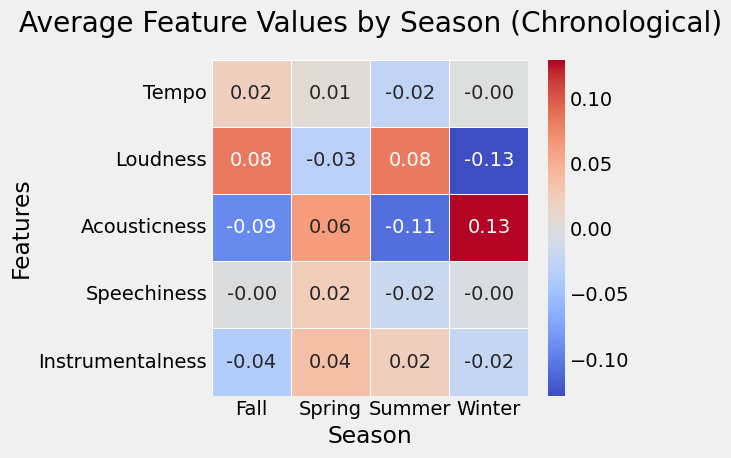

<Figure size 640x480 with 0 Axes>

In [23]:
normalized_data = hits.copy()
for feature in top_features:
    normalized_data[feature] = (normalized_data[feature] - normalized_data[feature].mean()) / normalized_data[feature].std()
seasonal_avg = normalized_data.groupby("season")[top_features].mean()
seasonal_order = ["Spring", "Summer", "Fall", "Winter"]
seaonal_avg = seasonal_avg.loc[seasonal_order]

plt.Figure(figsize=(8,5))
sns.heatmap(seasonal_avg.T, annot=True ,cmap = "coolwarm", fmt=".2f", linewidths=0.5, center=0)
plt.title("Average Feature Values by Season (Chronological)", pad=20)
plt.xlabel("Season")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
plt.savefig("../Images/average_features_by_season.png")

## Summary: Feature Relationships and Seasonal Trends
---

In this notebook, we analyzed how individual audio features relate to a song's chart success and how those relationships shift across seasons and decades.

---
### Features Importance

- **Point Biserial Correlation** showed only weak linear relationships between features and hit status.
- **Mutual Information** captured non-linear dependencies  better. Features with the higher MI scores were:
    - `Tempo` (0.13)
    - `Loudness` (0.11)
    - `Acousticness`, `Speechiness` and `Instrumentalness` also had meaningful influence]].

---

### Statistical Testing

- **T-tests** revealed statistically significant differences between hits and non-hits for the top 5 features, confirming that these features are distributed differently based on chart success.

--- 

### Behaviour Patterns  

- **Hit rate binning** uncovered peak hit probabilities at specific ranges (e.g. moderate `loudness` and `speechiness`), highlighting that hit likelihood is often **non-linear**.
- **Pairplots** showed low linear separability, suggesting interactions and feature combinations matter more than individual values.

--- 

### Temporal Variation

- **Anova by Decade** 
    - `Acousticness`, `Speechiness`, and `Loudness` exhibited strong temporal shifts in hit tracks.
    - Hits in the 2020s have wider spread and variance compared to earlier decades.
- **Violin plots by hit status and decade** showed that:
    - `Loudness` in hits have grown tighter and louder over time.
    - `Acousticness` and `Instrumentalness` have dropped slightly, especially in modern hits.

---

### Seasonal Trends

- **Seasonal Anova** revealed:
    - `Loudness` and `Acousticness` varied signficantly across seasons.
    - Turkey HSD confirmed Winter often differs significantly from other seasons for those features.
- **Normalized Heatmap** made these shifts visually interpretable:
    - Winter: quieter, more acoustic. 
    - Summer/Fall: louder, more energetic.

----

### Final Insights 

No single feature define a hit, but a **combination of feature values**, their **distribution over time** and **seasonal alignment** all contribute to the success of a song. These insights help frame the next step: modeling hit probability using these multidimensional factors.